## Tutorial 25 - V-n Diagram
Welcome to this tutorial on performing V-n diagram analysis of a turbofan aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## 1. Header and Imports


The **Imports** section is divided into two parts: general-purpose Python libraries and simulation-specific libraries.

In [1]:
import numpy as np 
import sys
import os
import numpy as np

## 2. RCAIDE Imports

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.

### Key Imports:

1. **RCAIDE**: The core package is imported directly. This approach allows us to access specific classes and methods from RCAIDE without repeatedly importing individual components at the top of the script.

2. **`Units` Module**: The Units module is a standardized way to handle unit conversions within RCAIDE. It ensures consistent units across all inputs and outputs, reducing the likelihood of conversion errors.

In [2]:
import RCAIDE
from RCAIDE.Framework.Core   import Data,Units 
from RCAIDE.Library.Methods.Performance  import generate_V_n_diagram
from RCAIDE.Library.Methods.Propulsors.Converters.Rotor import design_propeller

# Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

A detailed description of the vehicle setup is provided in the a tutorial coming soon.

In [3]:
def vehicle_setup(): 
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ################################################# Vehicle-level Properties ########################################################  
    #------------------------------------------------------------------------------------------------------------------------------------     
    vehicle                                     = RCAIDE.Vehicle()
    vehicle.tag                                 = 'Cessna_172' 
    vehicle.mass_properties.max_takeoff         = 2550. * Units.pounds
    vehicle.mass_properties.takeoff             = 2550. * Units.pounds
    vehicle.mass_properties.max_zero_fuel       = 2550. * Units.pounds
    vehicle.mass_properties.cargo               = 0. 
                                               
    # envelope properties                       
    vehicle.flight_envelope.ultimate_load       = 5.7 
    vehicle.flight_envelope.positive_limit_load = 3.8  
                                                
    cruise_speed                                = 124. * Units.kts
    altitude                                    = 8500. * Units.ft
    atmo                                        = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    freestream                                  = atmo.compute_values (0.)
    freestream0                                 = atmo.compute_values (altitude)
    mach_number                                 = (cruise_speed/freestream.speed_of_sound)[0][0] 
    vehicle.design_dynamic_pressure             = ( .5 *freestream0.density*(cruise_speed*cruise_speed))[0][0]
    vehicle.flight_envelope.design_mach_number  =  mach_number
                                                
    # basic parameters                          
    vehicle.reference_area                      = 174. * Units.feet**2       
    vehicle.passengers                          = 4


    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##################################################### Landing Gear ################################################################    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    main_gear                                   = RCAIDE.Library.Components.Landing_Gear.Main_Landing_Gear()
    main_gear.strut_length                      = 12. * Units.inches
    vehicle.append_component(main_gear) 
    nose_gear                                   = RCAIDE.Library.Components.Landing_Gear.Nose_Landing_Gear()    
    nose_gear.strut_length                      = 6. * Units.inches 
    vehicle.append_component(nose_gear)


    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------   

    wing                                        = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                                    = 'main_wing'    
    wing.sweeps.quarter_chord                   = 0.0 * Units.deg
    wing.thickness_to_chord                     = 0.12
    wing.areas.reference                        = 174. * Units.feet**2
    wing.spans.projected                        = 36.  * Units.feet + 1. * Units.inches
    wing.chords.root                            = 66. * Units.inches
    wing.chords.tip                             = 45. * Units.inches
    wing.chords.mean_aerodynamic                = 58. * Units.inches
    wing.taper                                  = wing.chords.tip/wing.chords.root
    wing.aspect_ratio                           = wing.spans.projected**2. / wing.areas.reference
    wing.twists.root                            = 3.0 * Units.degrees
    wing.twists.tip                             = 1.5 * Units.degrees
    wing.origin                                 = [[80.* Units.inches,0,0]]
    wing.aerodynamic_center                     = [22.* Units.inches,0,0]
    wing.vertical                               = False
    wing.symmetric                              = True
    wing.high_lift                              = True 
    wing.dynamic_pressure_ratio                 = 1.0 
                                          
    # control surfaces -------------------------------------------
    flap                                        = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap() 
    flap.tag                                    = 'flap' 
    flap.span_fraction_start                    = 0.15 
    flap.span_fraction_end                      = 0.324    
    flap.deflection                             = 1.0 * Units.deg
    flap.chord_fraction                         = 0.19    
    wing.append_control_surface(flap)           
                                                
    slat                                        = RCAIDE.Library.Components.Wings.Control_Surfaces.Slat() 
    slat.tag                                    = 'slat' 
    slat.span_fraction_start                    = 0.324 
    slat.span_fraction_end                      = 0.963     
    slat.deflection                             = 1.0 * Units.deg
    slat.chord_fraction                         = 0.1      
    wing.append_control_surface(slat)  
    
    RCAIDE.Library.Methods.Geometry.Planform.wing_planform(wing) 

    # add to vehicle
    vehicle.append_component(wing)


    # ------------------------------------------------------------------        
    #  Horizontal Stabilizer
    # ------------------------------------------------------------------        
                                                
    wing                                        = RCAIDE.Library.Components.Wings.Horizontal_Tail()
    wing.tag                                    = 'horizontal_stabilizer' 
    wing.sweeps.quarter_chord                   = 0.0 * Units.deg
    wing.thickness_to_chord                     = 0.12
    wing.areas.reference                        = 5800. * Units.inches**2
    wing.spans.projected                        = 136.  * Units.inches
    wing.chords.root                            = 55. * Units.inches
    wing.chords.tip                             = 30. * Units.inches
    wing.chords.mean_aerodynamic                = 43. * Units.inches 
    wing.taper                                  = wing.chords.tip/wing.chords.root
    wing.aspect_ratio                           = wing.spans.projected**2. / wing.areas.reference
    wing.twists.root                            = 0.0 * Units.degrees
    wing.twists.tip                             = 0.0 * Units.degrees
    wing.origin                                 = [[246.* Units.inches,0,0]]
    wing.aerodynamic_center                     = [20.* Units.inches,0,0]
    wing.vertical                               = False
    wing.symmetric                              = True
    wing.high_lift                              = False 
    wing.dynamic_pressure_ratio                 = 0.9
    vehicle.append_component(wing)


    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------

    wing                                        = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag                                    = 'vertical_stabilizer' 
    wing.sweeps.quarter_chord                   = 25. * Units.deg
    wing.thickness_to_chord                     = 0.12
    wing.areas.reference                        = 3500. * Units.inches**2
    wing.spans.projected                        = 73.   * Units.inches
    wing.chords.root                            = 66. * Units.inches
    wing.chords.tip                             = 27. * Units.inches
    wing.chords.mean_aerodynamic                = 48. * Units.inches 
    wing.taper                                  = wing.chords.tip/wing.chords.root
    wing.aspect_ratio                           = wing.spans.projected**2. / wing.areas.reference
    wing.twists.root                            = 0.0 * Units.degrees
    wing.twists.tip                             = 0.0 * Units.degrees
    wing.origin                                 = [[237.* Units.inches,0,0]]
    wing.aerodynamic_center                     = [20.* Units.inches,0,0] 
    wing.vertical                               = True 
    wing.symmetric                              = False
    wing.t_tail                                 = False 
    wing.dynamic_pressure_ratio                 = 1.0

    # add to vehicle
    vehicle.append_component(wing)


    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################## Fuselage ############################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------
    
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Tube_Fuselage() 
    fuselage.number_coach_seats                 = 4.        
    fuselage.differential_pressure              = 8*Units.psi                    # Maximum differential pressure
    fuselage.width                              = 42.         * Units.inches     # Width of the fuselage
    fuselage.heights.maximum                    = 62. * Units.inches    # Height of the fuselage
    fuselage.lengths.total                      = 326.         * Units.inches            # Length of the fuselage
    fuselage.lengths.tail                       = 161. * Units.inches  
    fuselage.lengths.cabin                      = 105. * Units.inches 
    fuselage.mass_properties.volume             = .4*fuselage.lengths.total*(np.pi/4.)*(fuselage.heights.maximum**2.) #try this as approximation
    fuselage.mass_properties.internal_volume    = .3*fuselage.lengths.total*(np.pi/4.)*(fuselage.heights.maximum**2.)
    fuselage.areas.wetted                       = 30000. * Units.inches**2.
    fuselage.seats_abreast                      = 2.
    fuselage.fineness.nose                      = 1.6
    fuselage.fineness.tail                      = 2.
    fuselage.lengths.nose                       = 60.  * Units.inches
    fuselage.heights.at_quarter_length          = 62. * Units.inches
    fuselage.heights.at_three_quarters_length   = 62. * Units.inches
    fuselage.heights.at_wing_root_quarter_chord = 23. * Units.inches
    fuselage.areas.front_projected              = fuselage.width* fuselage.heights.maximum
    fuselage.effective_diameter                 = 50. * Units.inches

    # add to vehicle
    vehicle.append_component(fuselage)
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################## Energy Network ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    #initialize the fuel network
    net                                         = RCAIDE.Framework.Networks.Fuel()   

    # add the network to the vehicle
    vehicle.append_energy_network(net) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus
    #------------------------------------------------------------------------------------------------------------------------------------  
    fuel_line                                   = RCAIDE.Library.Components.Energy.Distributors.Fuel_Line()   

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Fuel Tank & Fuel
    #------------------------------------------------------------------------------------------------------------------------------------       
    fuel_tank                                   = RCAIDE.Library.Components.Energy.Sources.Fuel_Tanks.Fuel_Tank() 
    fuel_tank.origin                            = vehicle.wings.main_wing.origin  
    fuel_tank.fuel                              = RCAIDE.Library.Attributes.Propellants.Aviation_Gasoline() 
    fuel_tank.fuel.mass_properties.mass         = 319 *Units.lbs 
    fuel_tank.mass_properties.center_of_gravity = wing.mass_properties.center_of_gravity
    fuel_tank.volume                            = fuel_tank.fuel.mass_properties.mass/fuel_tank.fuel.density   
    fuel_line.fuel_tanks.append(fuel_tank)   

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------   
    ice_prop    = RCAIDE.Library.Components.Propulsors.ICE_Propeller()     
    ice_prop.active_fuel_tanks                 = ['fuel_tank']   
                                                     
    # Engine                     
    engine                                     = RCAIDE.Library.Components.Propulsors.Converters.Engine()
    engine.sea_level_power                     = 180. * Units.horsepower
    engine.flat_rate_altitude                  = 0.0
    engine.rated_speed                         = 2700. * Units.rpm
    engine.power_specific_fuel_consumption     = 0.52 * Units['lb/hp/hr']
    ice_prop.engine                            = engine 
     
    # Propeller 
    prop = RCAIDE.Library.Components.Propulsors.Converters.Propeller()
    prop.tag                                = 'propeller'
    prop.number_of_blades                   = 2.0
    prop.tip_radius                         = 76./2. * Units.inches
    prop.hub_radius                         = 8.     * Units.inches
    prop.cruise.design_freestream_velocity  = 119.   * Units.knots
    prop.cruise.design_angular_velocity     = 2650.  * Units.rpm
    prop.cruise.design_Cl                   = 0.8
    prop.cruise.design_altitude             = 12000. * Units.feet
    prop.cruise.design_power                = .64 * 180. * Units.horsepower
    prop.variable_pitch                     = True  
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                               = os.path.sep
    rel_path                                = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator
    airfoil                                 = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.tag                             = 'NACA_4412' 
    airfoil.coordinate_file                 =  rel_path + 'Airfoils' + separator + 'NACA_4412.txt'   # absolute path   
    airfoil.polar_files                     =[ rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt']  
    prop.append_airfoil(airfoil)      
    prop.airfoil_polar_stations             = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  
    design_propeller(prop)    
    ice_prop.propeller                      = prop  
    net.propulsors.append(ice_prop)

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line to network      
    fuel_line.assigned_propulsors =  [[ice_prop.tag]]
    
    #------------------------------------------------------------------------------------------------------------------------------------   
    # Append fuel line to fuel line to network      
    net.fuel_lines.append(fuel_line)            

    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Avionics
    #------------------------------------------------------------------------------------------------------------------------------------ 
    Wuav                                        = 2. * Units.lbs
    avionics                                    = RCAIDE.Library.Components.Systems.Avionics()
    avionics.mass_properties.uninstalled        = Wuav
    vehicle.avionics                            = avionics     

    #------------------------------------------------------------------------------------------------------------------------------------ 
    #   Vehicle Definition Complete
    #------------------------------------------------------------------------------------------------------------------------------------ 

    return vehicle  

## Vehicle Aerodynamic Analysis Setup

The setup for aerodynamic analysis involves:

1. **Initialize Analyses**: Create a vehicle analysis object and append Earth as the planetary environment and the US Standard Atmosphere 1976 model.
2. **Define Conditions**: Set altitude (`0 m`) and ISA deviation (`0`).
3. **Vehicle Setup**: Configure the vehicle with `normal` category, FAR part `23`, and lift coefficient limits (`3` and `-1.5`).
4. **Generate V-n Diagram**: Calculate and plot the flight envelope using `generate_V_n_diagram`.


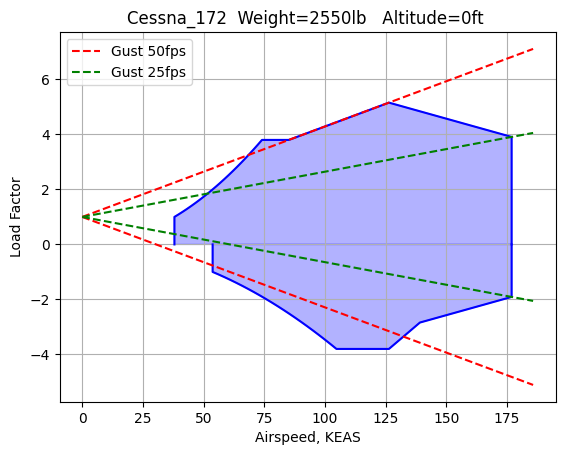

In [4]:
analyses = RCAIDE.Framework.Analyses.Vehicle()
# ------------------------------------------------------------------
#  Planet Analysis
planet = RCAIDE.Framework.Analyses.Planets.Earth()
analyses.append(planet)

# ------------------------------------------------------------------
#  Atmosphere Analysis
atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
atmosphere.features.planet = planet.features
analyses.append(atmosphere)      

altitude  = 0 * Units.m
delta_ISA = 0 

vehicle  = vehicle_setup()

vehicle.flight_envelope.category                  = 'normal'
vehicle.flight_envelope.FAR_part_number           = '23' 
vehicle.flight_envelope.maximum_lift_coefficient  = 3
vehicle.flight_envelope.minimum_lift_coefficient  = -1.5 

V_n_data = generate_V_n_diagram(vehicle,analyses,altitude,delta_ISA)  
